# Problem Identification

Since samples can be paired with labels, this is a Supervised Learning task. The predictions will be either 0 or 1, so this is a binary classification problem. 

# Imports


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from keras import models
from keras import layers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA, PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

# Exploratory Data Analysis

In [ ]:
def load_data(filename):
  return pd.read_csv(filename)
df = load_data('au_train.csv')
df.info()
# Number of samples >> number of features
# 6 continuous attributes and 9 categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
for i,attribute in enumerate(df.columns):
  if df[attribute].dtype == 'object':
    print(df[attribute].value_counts())
# missing counts: native-country - 583, occupation - 1843, workclass - 1836 
# significant class imbalance

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial

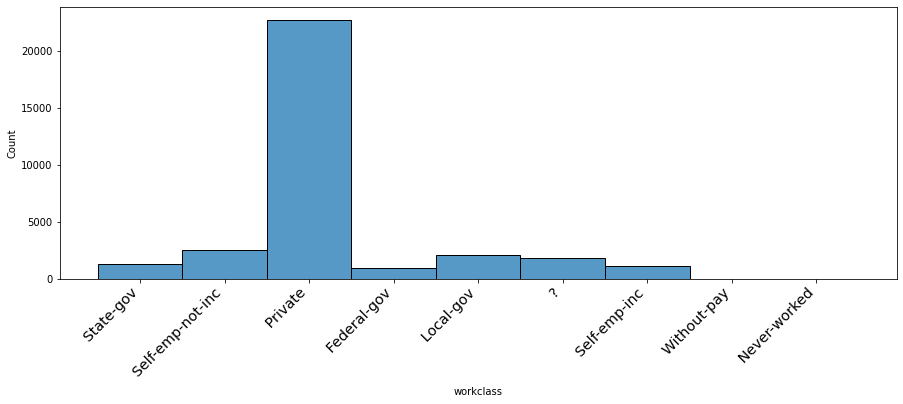

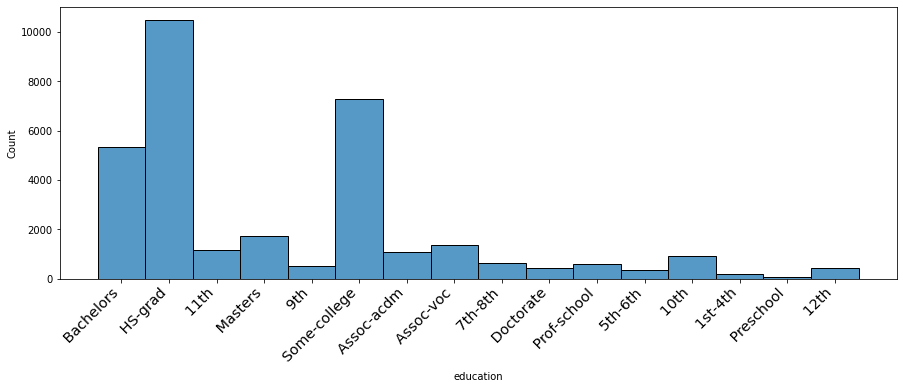

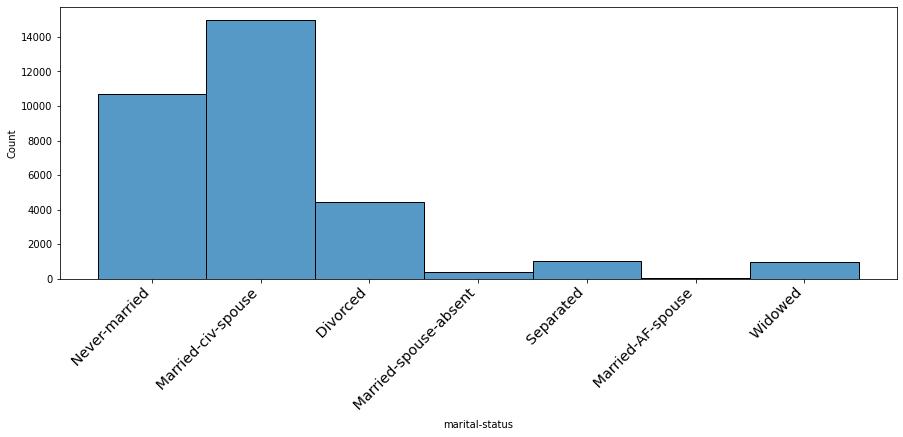

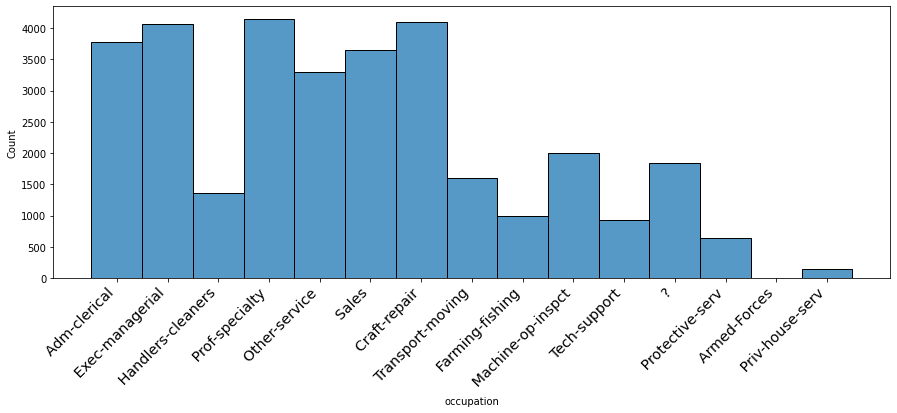

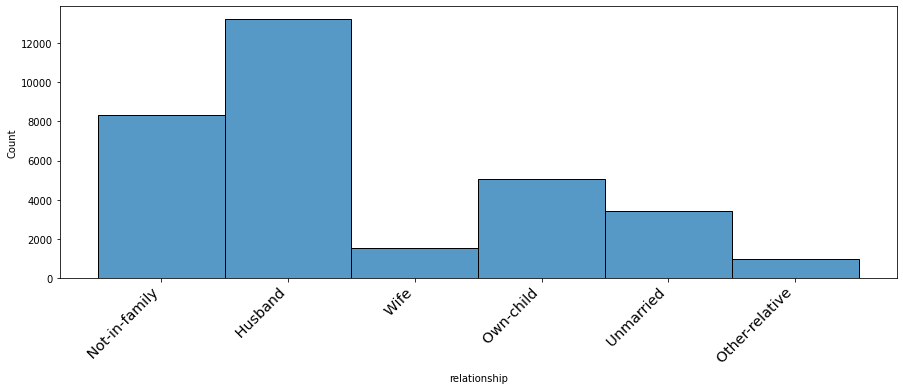

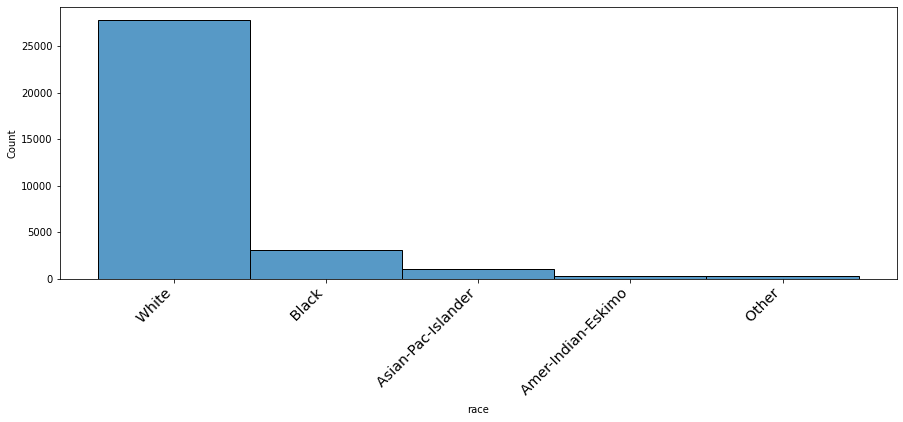

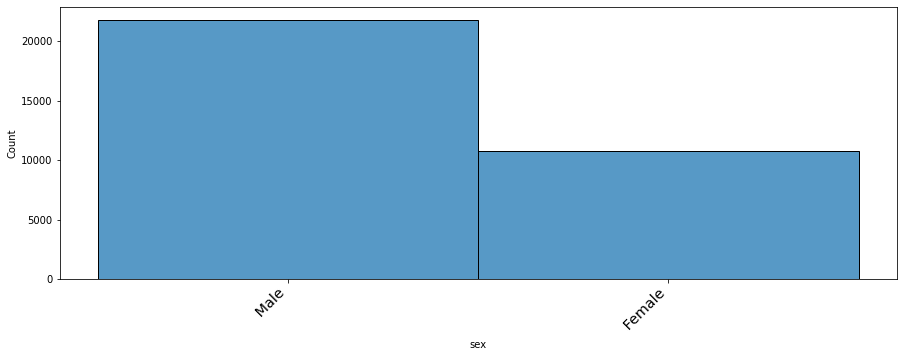

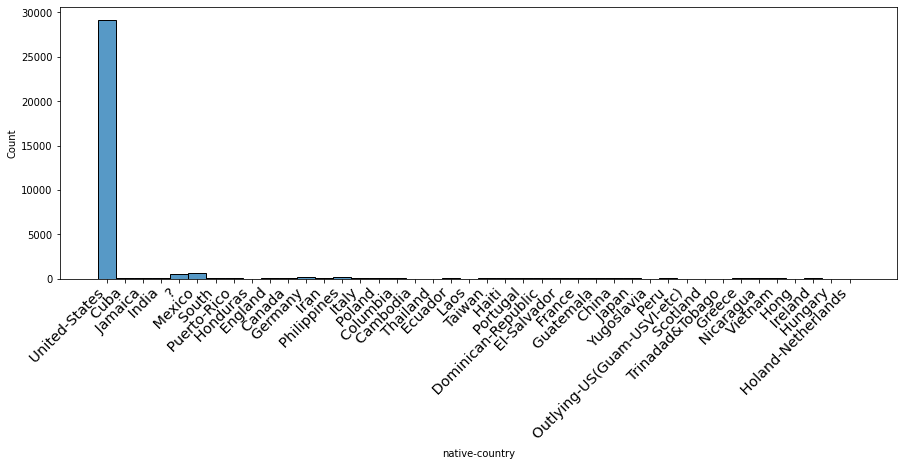

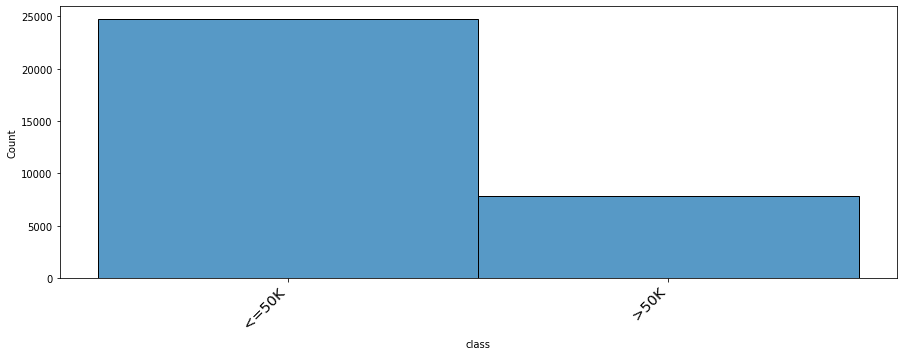

In [ ]:
for i,attribute in enumerate(df.columns):
  if df[attribute].dtype == 'object':
    plt.figure(i+1,figsize=(15,5))
    chart = sns.histplot(data=df[attribute])
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')

In [ ]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58b7c3e990>,
      dtype=object)

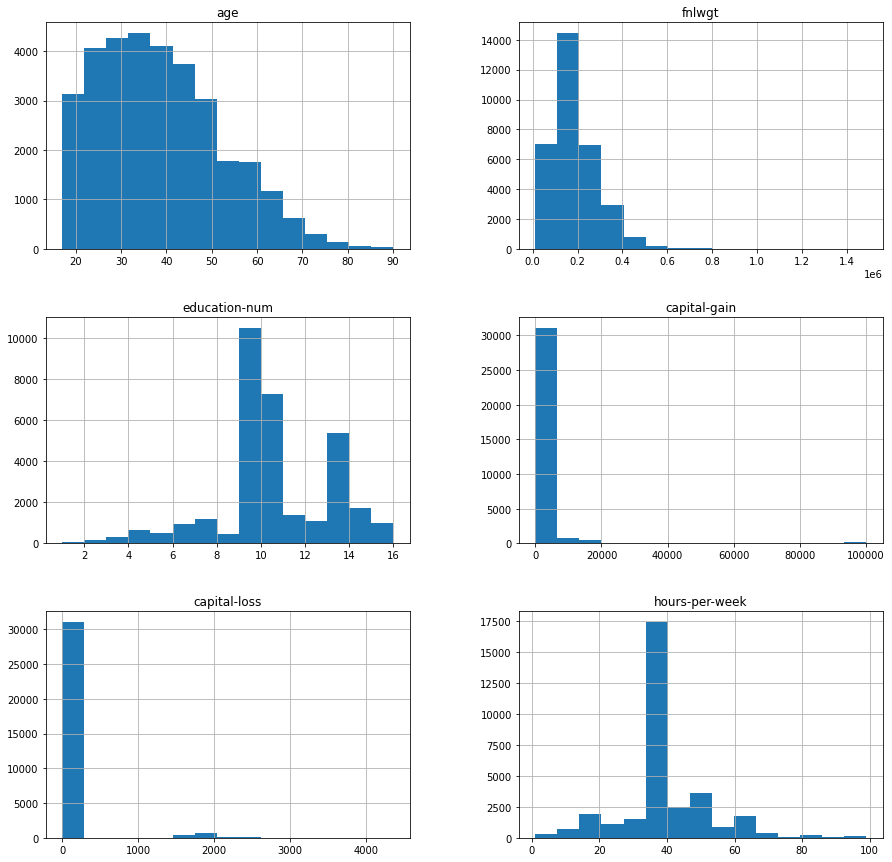

In [ ]:
df.hist(bins=15, figsize=(15,15))
# outliers significantly influencing mean value
# capital-gain attribute is capped at $99,999... count 159
# education-num attribute same as education... can discard one in next phase

In [ ]:
df.corr()
# linear correlation between capital-gain and education, as well as educat-num and hours per week.

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58b78cfb90>,
      dtype=object)

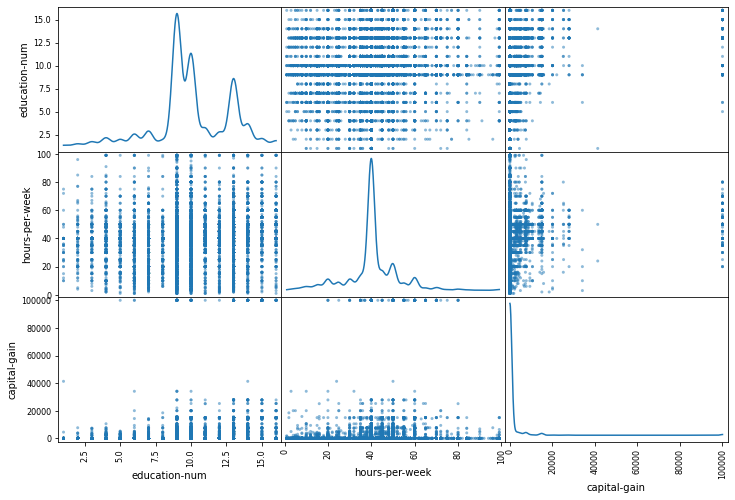

In [ ]:
pd.plotting.scatter_matrix(df[['education-num','hours-per-week','capital-gain']], figsize=(12, 8),diagonal = 'kde')


# Feature Engineering and Data Cleaning

## Handle Missing Data

In [ ]:
# Only 1 sample's native country is Holand-Netherlands. No need to create a new attribute because of this 1 sample.
def DropMissingData(data):
  return (data.replace([' ?',' Holand-Netherlands'],pd.NA)).dropna()
df = DropMissingData(df)

## Balance Class Distribution

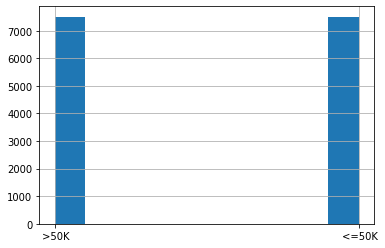

In [ ]:
def BalanceClassDistrbution(df):
  class_count_0, class_count_1 = df['class'].value_counts()
  # separate samples by class
  df_0 = df[df['class'] == ' <=50K']
  df_1 = df[df['class'] == ' >50K'] 
  df_0 = df_0.sample(class_count_1)
  # cancatenate and randomize samples
  return pd.concat([df_0, df_1], axis=0).sample(frac=1,random_state=1)
df = BalanceClassDistrbution(df)
df['class'].hist()

## One-Hot Encoding

In [ ]:
class OneHotEncode(BaseEstimator, TransformerMixin):
  def fit(self,X,y=None):
    return self
  def transform(self,data):
    cat_encoder = OneHotEncoder()
    return cat_encoder.fit_transform(data)


## Feature Scaling

In [ ]:
class Standardize(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.transformer = StandardScaler()

  def fit(self,fit_data,y=None):
    self.transformer.fit(fit_data)
    return self
  def transform(self,transform_data):
    return self.transformer.transform(transform_data)

## Feature Selection



In [ ]:
X = df.drop(columns = ['class','fnlwgt','education-num'])
y = df['class'].copy().replace([' <=50K',' >50K'],[0,1])

num_attribs = X.select_dtypes(include=['int64']).columns
cat_attribs = X.select_dtypes(include=['object']).columns
pipeline = ColumnTransformer([
                              ("cat", OneHotEncode(), cat_attribs),
                              ("num", Standardize(), num_attribs),
                              ])

X_prepared = pipeline.fit_transform(X).toarray()

# Machine Learning

## Dense Neural Network

In [ ]:
x_val = X_prepared[:4000]
x_train = X_prepared[4000:]
y_val = y[:4000]
y_train = y[4000:]
# create model
network = models.Sequential()
network.add(layers.Dense(16, activation='relu', input_shape=(x_train.shape[1],)))
network.add(layers.Dense(16, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

network.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = network.fit(x_train,
                    y_train,
                    epochs=50,
                    validation_data=(x_val, y_val))

Epoch 1/50
345/345 [==============================] - 5s 5ms/step - loss: 0.4933 - accuracy: 0.7635 - val_loss: 0.4046 - val_accuracy: 0.8108
Epoch 2/50
345/345 [==============================] - 1s 4ms/step - loss: 0.3911 - accuracy: 0.8194 - val_loss: 0.3869 - val_accuracy: 0.8213
Epoch 3/50
345/345 [==============================] - 1s 4ms/step - loss: 0.3805 - accuracy: 0.8258 - val_loss: 0.3815 - val_accuracy: 0.8223
Epoch 4/50
345/345 [==============================] - 1s 4ms/step - loss: 0.3761 - accuracy: 0.8258 - val_loss: 0.3815 - val_accuracy: 0.8215
Epoch 5/50
345/345 [==============================] - 2s 4ms/step - loss: 0.3728 - accuracy: 0.8285 - val_loss: 0.3852 - val_accuracy: 0.8230
Epoch 6/50
345/345 [==============================] - 2s 5ms/step - loss: 0.3701 - accuracy: 0.8281 - val_loss: 0.3784 - val_accuracy: 0.8255
Epoch 7/50
345/345 [==============================] - 1s 4ms/step - loss: 0.3684 - accuracy: 0.8302 - val_loss: 0.3770 - val_accuracy: 0.8248
Epoch 

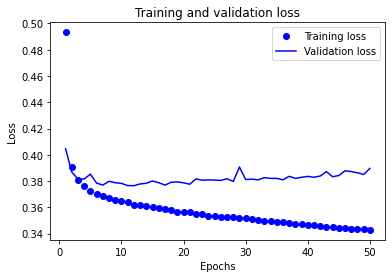

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

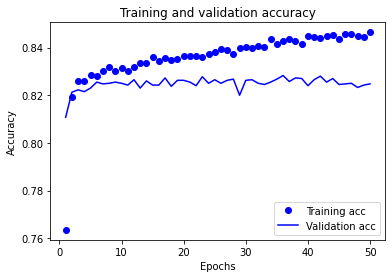

In [ ]:
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

125/125 [==============================] - 0s 1ms/step
Accuracy: 0.82475
Precision: 0.8255698711595639
Recall: 0.8267990074441688
AUROC: 0.906727628429099


Text(0.5, 1.0, 'Neural Network Confusion matrix')

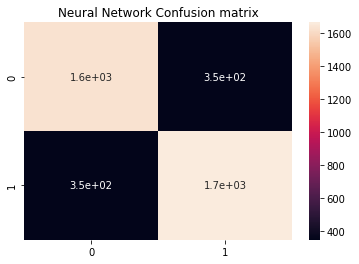

In [ ]:
y_pred = y_prob_nn = network.predict(x_val)
y_pred = y_pred > .5
print('Accuracy:',accuracy_score(y_val,y_pred))
print('Precision:',precision_score( y_val, y_pred))
print('Recall:',recall_score(y_val,y_pred))
print('AUROC:',roc_auc_score(y_val,y_prob_nn))
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_val,y_prob_nn)
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True) 
plt.title('Neural Network Confusion matrix')

## Logistic Regression

Cross Validation Accuracy: [0.82190413 0.82650683 0.82251082 0.82317682 0.81085581]
Hold Out Validation Accuracy: 0.82125
Precision: 0.8071833648393195
Recall: 0.8476426799007444
AUROC: 0.9039317211593152


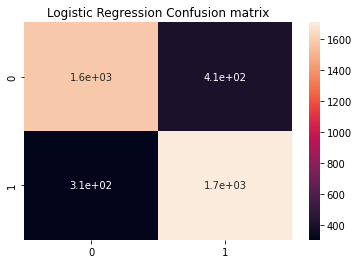

In [ ]:
log_reg = LogisticRegression(max_iter=250)
cross_val_accuracy = cross_val_score(log_reg,X_prepared,y,scoring = 'accuracy', cv = 5)
print('Cross Validation Accuracy:',cross_val_accuracy)
log_reg.fit(x_train,y_train)
y_pred = log_reg.predict(x_val)
y_prob_lr = log_reg.predict_proba(x_val)[:,1]
print('Hold Out Validation Accuracy:',accuracy_score(y_val,y_pred))
print('Precision:',precision_score( y_val, y_pred))
print('Recall:',recall_score(y_val,y_pred))
print('AUROC:',roc_auc_score(y_val,y_prob_lr))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True) 
plt.title('Logistic Regression Confusion matrix')
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_val,y_prob_lr)

# Hold out validation accuracy is similar to the cross validation accuracies. 
# This indicates that hold out validation should suffice to evaluate performance.

## Support Vector Machine

Accuracy: 0.81975
Precision: 0.7965169569202566
Recall: 0.862531017369727
AUROC: 0.9060030876736817


Text(0.5, 1.0, 'Support Vector Machine Confusion matrix')

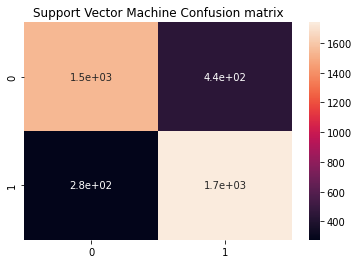

In [ ]:
svm = SVC(kernel = 'rbf',probability=True)
svm.fit(x_train,y_train)
y_pred = svm.predict(x_val)
y_prob_svm = svm.predict_proba(x_val)[:,1]
print('Accuracy:',accuracy_score(y_val,y_pred))
print('Precision:',precision_score( y_val, y_pred))
print('Recall:',recall_score(y_val,y_pred))
print('AUROC:',roc_auc_score(y_val,y_prob_svm))
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val,y_prob_svm)
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True) 
plt.title('Support Vector Machine Confusion matrix')

## K-Nearest Neighbors

Accuracy: 0.806
Precision: 0.7837837837837838
Recall: 0.8491315136476427
AUROC: 0.8819309836178285


Text(0.5, 1.0, 'K-Nearest Neighbors Confusion matrix')

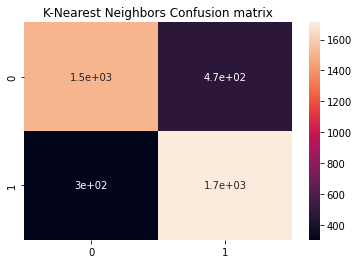

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_val)
y_prob_knn = knn.predict_proba(x_val)[:,1]
print('Accuracy:',accuracy_score(y_val,y_pred))
print('Precision:',precision_score( y_val, y_pred))
print('Recall:',recall_score(y_val,y_pred))
print('AUROC:',roc_auc_score(y_val,y_prob_knn))
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val,y_prob_knn)
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True) 
plt.title('K-Nearest Neighbors Confusion matrix')

## Random Forest

Accuracy: 0.805
Precision: 0.7770300583221176
Recall: 0.8595533498759306
AUROC: 0.8947704558381409


Text(0.5, 1.0, 'Random Forest Confusion matrix')

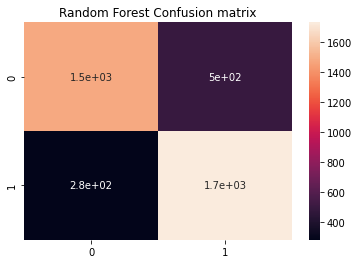

In [ ]:
rand_for = RandomForestClassifier(n_estimators=50, max_leaf_nodes=32, n_jobs=-1,bootstrap=True)

rand_for.fit(x_train,y_train)
y_pred = rand_for.predict(x_val)
y_prob_rf = rand_for.predict_proba(x_val)[:,1]
print('Accuracy:',accuracy_score(y_val,y_pred))
print('Precision:',precision_score( y_val, y_pred))
print('Recall:',recall_score(y_val,y_pred))
print('AUROC:',roc_auc_score(y_val,y_prob_rf))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val,y_prob_rf)
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True) 
plt.title('Random Forest Confusion matrix')

## Wisdom of the Crowd: Creating an Ensemble with Hard and Soft Voting Schemes


Accuracy: 0.81725
Precision: 0.8060057197330791
Recall: 0.8392059553349875


Text(0.5, 1.0, 'Hard Voting Classifier Confusion matrix')

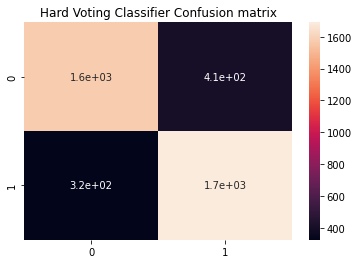

In [ ]:
hard_voting_clf = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=250)), ('rf', RandomForestClassifier(n_estimators=50, max_leaf_nodes=32, n_jobs=-1,bootstrap=True)), ('svc', SVC(kernel = 'rbf')),('knn',KNeighborsClassifier(n_neighbors=15))],
    voting='hard')
hard_voting_clf.fit(x_train,y_train)
y_pred = hard_voting_clf.predict(x_val)
print('Accuracy:',accuracy_score(y_val,y_pred))
print('Precision:',precision_score( y_val, y_pred))
print('Recall:',recall_score(y_val,y_pred))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True) 
plt.title('Hard Voting Classifier Confusion matrix')


Accuracy: 0.8185
Precision: 0.7968678028558268
Recall: 0.858560794044665
AUROC: 0.9057280722040614


Text(0.5, 1.0, 'Soft Voting Classifier Confusion matrix')

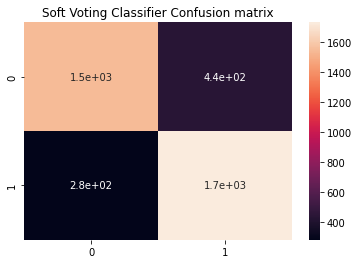

In [ ]:
soft_voting_clf = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=250)), ('rf', RandomForestClassifier(n_estimators=50, max_leaf_nodes=32, n_jobs=-1,bootstrap=True)), ('svc', SVC(kernel = 'rbf',probability=True)),('knn',KNeighborsClassifier(n_neighbors=15))],
    voting='soft')
soft_voting_clf.fit(x_train,y_train)
y_pred = soft_voting_clf.predict(x_val)
y_prob_soft_voting = soft_voting_clf.predict_proba(x_val)[:,1]
print('Accuracy:',accuracy_score(y_val,y_pred))
print('Precision:',precision_score( y_val, y_pred))
print('Recall:',recall_score(y_val,y_pred))
print('AUROC:',roc_auc_score(y_val,y_prob_soft_voting))
fpr_soft_voting, tpr_soft_voting, thresholds_soft_voting = roc_curve(y_val,y_prob_soft_voting)
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True) 
plt.title('Soft Voting Classifier Confusion matrix')

## Comparing ROC Curves

Text(0.5, 1.0, 'ROC Curves')

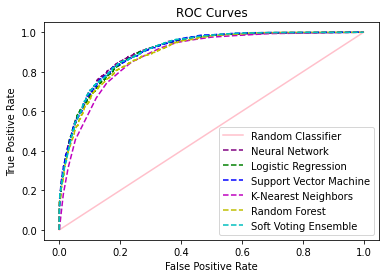

In [ ]:
plt.plot([0, 1], [0, 1], '-',color = 'pink',label = 'Random Classifier')
plt.plot(fpr_nn, tpr_nn, linestyle = '--', color = 'purple',label = 'Neural Network')
plt.plot(fpr_lr, tpr_lr, 'g--',label = 'Logistic Regression')
plt.plot(fpr_svm, tpr_svm, 'b--',label = 'Support Vector Machine')
plt.plot(fpr_knn, tpr_knn, 'm--',label = 'K-Nearest Neighbors') 
plt.plot(fpr_rf, tpr_rf, 'y--',label = 'Random Forest')
plt.plot(fpr_soft_voting, tpr_soft_voting, 'c--',label = 'Soft Voting Ensemble')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')

## Measuring Feature Importance 


In [ ]:
cat_data = X.select_dtypes(include=['object'])
num_data = X.select_dtypes(include=['int64'])
stdscaler = StandardScaler()
num_df = pd.DataFrame(stdscaler.fit_transform(num_data),index = num_data.index,columns = num_data.columns)
onehotenc = OneHotEncoder()
transformed_data = onehotenc.fit_transform(cat_data).toarray()
categorical_attributes = []
for arr in onehotenc.categories_:
  for element in arr:
    categorical_attributes.append(element)
transformed_data_df = pd.DataFrame(transformed_data,index = cat_data.index,columns = categorical_attributes)
transformed_data_df = transformed_data_df.join(num_df)

x_val = transformed_data_df[:4000]
x_train = transformed_data_df[4000:]

y_val = y[:4000]
y_train = y[4000:]

rnd_clf_feature_importance = RandomForestClassifier(n_estimators=50, max_leaf_nodes=32, n_jobs=-1,bootstrap=True)
rnd_clf_feature_importance.fit(x_train,y_train)
pd.Series(rnd_clf_feature_importance.feature_importances_.T,index=x_val.columns).nlargest(5)

 Married-civ-spouse    0.201322
 Husband               0.119770
capital-gain           0.099011
 Never-married         0.093798
age                    0.070687
dtype: float64

## Maximizing Performance

In [ ]:
soft_voting_clf = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter = 250)), ('rf', RandomForestClassifier( n_jobs=-1,bootstrap=True)), ('svc', SVC(probability=True)),('knn',KNeighborsClassifier(n_neighbors=15))],
    voting='soft')
parameters = {'rf__n_estimators':[25,50],'rf__max_leaf_nodes':[16,32,64],'svc__kernel':['rbf','poly','linear']}
grid_search = GridSearchCV(soft_voting_clf,parameters,cv=3)
grid_search.fit(transformed_data_df,y)

GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression(max_iter=250)),
                                                    ('rf',
                                                     RandomForestClassifier(n_jobs=-1)),
                                                    ('svc',
                                                     SVC(probability=True)),
                                                    ('knn',
                                                     KNeighborsClassifier(n_neighbors=15))],
                                        voting='soft'),
             param_grid={'rf__max_leaf_nodes': [16, 32, 64],
                         'rf__n_estimators': [25, 50],
                         'svc__kernel': ['rbf', 'poly', 'linear']})

In [ ]:
grid_search.best_params_

{'rf__max_leaf_nodes': 64, 'rf__n_estimators': 50, 'svc__kernel': 'rbf'}

In [ ]:
optimized_model = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter = 250)), ('rf', RandomForestClassifier( max_leaf_nodes=64,n_estimators=50, n_jobs=-1,bootstrap=True)), ('svc', SVC(probability=True,kernel = 'rbf')),('knn',KNeighborsClassifier(n_neighbors=15))],
    voting='soft')
optimized_model.fit(transformed_data_df,y)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=250)),
                             ('rf',
                              RandomForestClassifier(max_leaf_nodes=64,
                                                     n_estimators=50,
                                                     n_jobs=-1)),
                             ('svc', SVC(probability=True)),
                             ('knn', KNeighborsClassifier(n_neighbors=15))],
                 voting='soft')

## Performance on Test Data

In [ ]:
df_test = load_data('au_test.csv')
df_test = DropMissingData(df_test)
y_test = df['class'].copy().replace([' <=50K',' >50K'],[0,1])
X_test = pd.DataFrame(pipeline.transform(df.drop(columns = ['class','fnlwgt','education-num'])).toarray(),columns = transformed_data_df.columns)
y_pred = optimized_model.predict(X_test)
y_proba = optimized_model.predict_proba(X_test)[:,1]

*********Performance*********
Accuracy: 84%
Precision: 81%
Recall: 88%
AUROC: 0.92


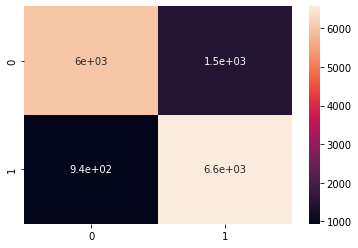

In [ ]:
print('*********Performance*********')
print('Accuracy: ' + str(int(100 * round(accuracy_score(y_test,y_pred),2))) + '%')
print('Precision: ' + str(int(100 * round(precision_score(y_test,y_pred),2))) + '%')
print('Recall: ' + str(int(100 * round(recall_score(y_test,y_pred),2))) + '%')
print('AUROC: ' + str(round(roc_auc_score(y_test,y_proba),2)))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True) 

# Summary of Insights Discovered

**Exploratory Data Analysis**


1. Number of samples >> number of features.
2. Native country, occupation, and workclass have missing data.
3. Missing data is represented with ' ?'.
4. Significant class imbalance.
5. Capital gain attribute is capped at 99,999. The outliers significantly influence the attribute's mean value.
6. The attribute education-num is a numerical represention of the categorical attribute education.
7. There is a positive linear correlation between capital gain and education, as well as hours worked per week and education.

**Machine Learning**

1. Marital status and age are the best features for determining whether a person makes greater than 50K.
2. The best performing model had an 83% accuracy, 81% precision, 88% recall, and an AUROC score of .92, indicating that machine learning algorithms can be used to reliably predict class labels.

